In [36]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import backend as K

from scipy.io import wavfile # scipy library to read wav files
from scipy.fftpack import fft # fourier transform
from scipy import signal

import librosa.display
import pylab
import librosa    
import glob
import os
import pandas as pd
import numpy as np
import cv2
import subprocess
import matplotlib.pyplot as plt

# from utilities import f1_m, recall_m, precision_m

In [2]:
# global variables
train_dir = os.getcwd() + "/train_data/"
val_dir = os.getcwd() + "/val_data/"
test_dir = os.getcwd() + "/test_data/"

train_audio_dir = os.getcwd() + "/extracted_train_audio/"
val_audio_dir = os.getcwd() + "/extracted_val_audio/"
test_audio_dir = os.getcwd() + "/extracted_test_audio/"

#directory to save extracted data
extracted_data_dir = os.getcwd() + "/extracted_audio_data/"
# os.mkdir(extracted_data_dir)

# Create a dataframe which contains multiclass classification content annotations for each video scene used in the training set.
train_df = pd.read_csv('train-updated.csv', dtype={'combination': object}).iloc[:,1:]
train_df["path"] = train_dir + train_df["Video ID"]+ ".0" + train_df["Scene_ID"].astype(str) + ".mp4"

# Create a dataframe which contains multiclass classification content annotations for each video scene used in the validation set.
val_df = pd.read_csv('val.csv', dtype={'combination': object}).iloc[:,1:]
val_df["path"] = val_dir + val_df["Video ID"]+ ".0" + val_df["Scene_ID"].astype(str) + ".mp4"

# Create a dataframe which contains multiclass classification content annotations for each video scene used in the test set.
test_df = pd.read_csv('test-updated.csv', dtype={'combination': object}).iloc[:,1:]
test_df["path"] = test_dir + test_df["Video ID"]+ ".0" + test_df["Scene_ID"].astype(str) + ".mp4"



## Extract audio

In [37]:
subprocess.call(["ffmpeg", "-y", "-i", "tt2872718.00.mp4", "test_audio.wav"], 
                stdout=subprocess.DEVNULL,
                stderr=subprocess.STDOUT)

0

## Extract mel spectrogram

In [3]:
def extract_mel_spectrograms(audio_dir):
    # Load the audio wav file into numpy array
    audio_data, samplerate = librosa.load(audio_dir)
    # print(audio_data.shape)
    # print(samplerate)

    #Compute a mel-scaled spectrogram
    mel_feat = librosa.feature.melspectrogram(y=audio_data, sr=samplerate)
    librosa.display.specshow(mel_feat)
    power = librosa.power_to_db(mel_feat,ref=np.max)
    # power = power.reshape(-1,1)
    return power

In [6]:
def prepare_all_spectrograms(df, audio_root_dir):
    video_paths = df["path"].values.tolist()
    video_ids = df["Video ID"].values.tolist()
    scene_ids = df["Scene_ID"].values.tolist()

    audio_features = []
    # For each video.
    for idx, path in enumerate(video_paths):
        print(path)
        video_id = video_ids[idx]
        scene_id = scene_ids[idx]

        audio_dir = audio_root_dir + str(video_id) + '.0' + str(scene_id) + '.wav'
        print(audio_dir)

        mel = extract_mel_spectrograms(audio_dir)

        audio_features.append(mel)

    audio_features = np.array(audio_features)
    print(audio_features.shape)
    return audio_features

In [49]:
def create_spectrogram(filename, audio_dir):
    # plt.interactive(False)
    clip, sample_rate = librosa.load(audio_dir, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    plt.show()
    # plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    # plt.close()    
    # fig.clf()
    # plt.close(fig)
    # plt.close('all')

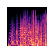

In [50]:
create_spectrogram("test_spec.jpg", "test_audio.wav")

In [17]:
def extract_all_spectrograms(df, audio_root_dir, save_dir):
    video_paths = df["path"].values.tolist()
    video_ids = df["Video ID"].values.tolist()
    scene_ids = df["Scene_ID"].values.tolist()

    # For each video.
    for idx, path in enumerate(video_paths):
        print(path)
        video_id = video_ids[idx]
        scene_id = scene_ids[idx]

        audio_dir = audio_root_dir + str(video_id) + '.0' + str(scene_id) + '.wav'
        print(audio_dir)

        save_filename = save_dir + str(video_id) + '.0' + str(scene_id) + '.jpg'
        print(save_filename)
        create_spectrogram(save_filename, audio_dir)

In [ ]:
# extracted_train_path = os.getcwd() + "/extracted_train_spectrogram/"
# extracted_val_path = os.getcwd() + "/extracted_val_spectrogram/"
# extracted_test_path = os.getcwd() + "/extracted_test_spectrogram/"
# # os.mkdir(extracted_train_path)
# # os.mkdir(extracted_val_path)
# # os.mkdir(extracted_test_path)

# extract_all_spectrograms(train_df,train_audio_dir,extracted_train_path)
# extract_all_spectrograms(val_df,val_audio_dir,extracted_val_path)
# extract_all_spectrograms(test_df,test_audio_dir,extracted_test_path)

## Train model

In [18]:
# Hyperparameters
IMG_SIZE = 224
EPOCHS = 20
BATCH_SIZE = 32

In [19]:
train_data, train_labels = np.load("extracted_audio_data/train_data.npy", allow_pickle=True), np.load("extracted_data/train_labels.npy")
val_data, val_labels = np.load("extracted_audio_data/val_data.npy", allow_pickle=True), np.load("extracted_data/val_labels.npy")
test_data, test_labels = np.load("extracted_audio_data/test_data.npy", allow_pickle=True), np.load("extracted_data/test_labels.npy")

In [20]:
train_labels.shape

(942, 4)

In [21]:
train_spectrograms = glob.glob('extracted_train_spectrogram/*')
val_spectrograms = glob.glob('extracted_val_spectrogram/*')
test_spectrograms = glob.glob('extracted_test_spectrogram/*')

In [22]:
train_data = []
val_data = []
test_data = []

for f in train_spectrograms:
    img = cv2.imread(f)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    train_data.append(img)
    
train_data = np.array(train_data)

for f in val_spectrograms:
    img = cv2.imread(f)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    val_data.append(img)
    
val_data = np.array(val_data)

for f in test_spectrograms:
    img = cv2.imread(f)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    test_data.append(img)
    
test_data = np.array(test_data)

In [23]:
print(train_data.shape)

(942, 224, 224, 3)


In [24]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [30]:
def get_cnn_model():
    classes = 4

    # Create a VGG19 model, and removing the last layer that is classifying 1000 images. 
    # This will be replaced with images classes we have. 
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    # freeze all layers in the the base model
    base_model.trainable = False

    # Model = Model(inputs=base_model.input, outputs=base_model.get_layer('flatten').output)

    x = layers.Flatten()(base_model.output) #Output obtained on vgg16 is now flattened.
    outputs = layers.Dense(classes, activation="sigmoid")(x)

    #Creating model object 
    model = keras.Model(inputs=base_model.input, outputs=outputs)

    # optimizer = keras.optimizers.Adam(learning_rate=1e-4)
    optimizer = keras.optimizers.Adam()
    # compile the model
    model.compile(
        optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m]
    )

    model.summary()

    return model

In [31]:
def run_experiment():
    log_dir = "logs/fit/temp" 
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    filepath = os.getcwd() + "/temp/audio_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    # with tf.device('/device:CPU:0'):
    model = get_cnn_model()
    history = model.fit(
        train_data,
        train_labels,
        validation_data=(val_data,val_labels),
        epochs=EPOCHS,
        callbacks=[checkpoint, tensorboard_callback],
    )

    model.load_weights(filepath)
    # evaluate the model
    # _, accuracy = model.evaluate(test_data, test_labels)
   
    loss, accuracy, f1_score, precision, recall = model.evaluate(test_data, test_labels, verbose=0)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"F1 score: {round(f1_score, 2)}")
    print(f"Precision: {round(precision, 2)}")
    print(f"Recall: {round(recall, 2)}")

    return model

In [32]:
trained_model = run_experiment()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## Inference

In [119]:
# from keras.preprocessing import image

# Y_pred = []

# for i in range(len(test_set)):
#   img = image.load_img(path= test_set.Images[i],target_size=(256,256,3))
#   img = image.img_to_array(img)
#   test_img = img.reshape((1,256,256,3))
#   img_class = classifier.predict_classes(test_img)
#   prediction = img_class[0]
#   Y_pred.append(prediction)

img = cv2.imread('extracted_test_spectrogram/al-TxOuSqc8.02.jpg')
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
img = np.array(img)
# img = test_data[104]
img = img.reshape((1,IMG_SIZE,IMG_SIZE,3))
# print(img.shape)

y_pred = trained_model.predict(img)[0]

# round probabilities to class labels
y_pred = y_pred.round()


print(y_pred)

[0. 1. 0. 0.]


In [114]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
melspectrogram=train_data.reshape(942,-1)
print(melspectrogram.shape)

(942, 150528)


In [ ]:
scaler.fit(melspectrogram)
normalized_melspectrogram = scaler.transform(melspectrogram)

print(np.amax(melspectrogram))
print(np.amax(normalized_melspectrogram))

In [ ]:
features_convolution = np.reshape(melspectrogram,(942,128, -1,1))
#melspectrogram=melspectrogram.reshape(400,128, -1)
features_convolution.shape